In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [31]:
# 读取数据集
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# 定义离散特征和连续特征
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
continuous_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# 对标签进行二分类
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# 处理离散特征（独热编码）转换为DataFrame并添加列名
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_train = encoder.fit_transform(data[categorical_features])
encoded_categorical_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_features))

encoded_categorical_test = encoder.transform(data_test[categorical_features])
encoded_categorical_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_features))

# 保留连续特征
continuous_df_train = data[continuous_features]
continuous_df_test = data_test[continuous_features]

# 合并独热编码后的离散特征和连续特征
X_train = pd.concat([encoded_categorical_df_train, continuous_df_train], axis=1)
X_test = pd.concat([encoded_categorical_df_test, continuous_df_test], axis=1)

# 目标标签
Y_train = data['income']

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (32561, 108)
Y_train shape: (32561,)
X_test shape: (16281, 108)


In [32]:
# 标准化特征
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# 打印标准化后的结果
print("标准化后的训练集前两行：")
print(X_train_standardized[:1])
print(X_test_standardized[:1])


标准化后的训练集前两行：
[[-0.2444502  -0.17429511 -0.26209736 -0.01466381 -1.5167923  -0.18838933
  -0.29093568  4.90769968 -0.02073999 -0.17175325 -0.19348662 -0.11609195
  -0.07201601 -0.10164955 -0.1422718  -0.12664495 -0.18406376 -0.21053433
   2.25399324 -0.11334387 -0.68994199 -0.23637391 -0.03960742 -0.13419553
  -0.53714425 -0.39750806 -0.02658695 -0.92284068 -0.11403678  1.43105786
  -0.1802846  -0.17735813 -0.24494366  2.76348874 -0.01662771 -0.37949517
  -0.37774555 -0.17745022 -0.20957797 -0.25595432 -0.33554133 -0.06780164
  -0.38166338 -0.14260848 -0.35531609 -0.17127887 -0.22710355 -0.82533335
   1.70899099 -0.17624972 -0.42934582 -0.34403232 -0.22492681 -0.09820087
  -0.18155194 -0.32576824 -0.09161163  0.4130197  -0.70307135  0.70307135
  -0.13502327 -0.02416321 -0.06107342 -0.0480488  -0.04260602 -0.05409379
  -0.04641598 -0.02933708 -0.05714946 -0.05264698 -0.02985682 -0.06500204
  -0.02985682 -0.04437806 -0.03678503 -0.00554189 -0.01998525 -0.02479131
  -0.01998525 -0.05550333

In [33]:
# 定义 Sigmoid 函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 定义逻辑回归的损失函数（交叉熵损失）
def compute_loss(X, y, weights):
    m = len(y)
    h = sigmoid(X @ weights)
    epsilon = 1e-5  # 防止对数计算时出现零
    loss = (-1 / m) * (y @ np.log(h + epsilon) + (1 - y) @ np.log(1 - h + epsilon))
    return loss

# 梯度下降更新权重并记录损失和准确率
def gradient_descent(X, y, X_val, y_val, weights, learning_rate, num_iterations):
    m = len(y)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for i in tqdm(range(num_iterations), desc="Training Progress"):
        h = sigmoid(X @ weights)
        gradient = (1 / m) * X.T @ (h - y)
        weights -= learning_rate * gradient

        # 记录训练集损失和准确率
        train_loss = compute_loss(X, y, weights)
        train_accuracy = np.mean((h >= 0.5) == y)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 记录验证集损失和准确率
        val_h = sigmoid(X_val @ weights)
        val_loss = compute_loss(X_val, y_val, weights)
        val_accuracy = np.mean((val_h >= 0.5) == y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return weights, train_losses, val_losses, train_accuracies, val_accuracies

def mini_batch_gradient_descent(X, y, X_val, y_val, weights, learning_rate, num_iterations, batch_size):
    m = len(y)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for i in tqdm(range(num_iterations), desc="Training Progress"):
        # 随机打乱数据集
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # 分批进行梯度下降
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            h = sigmoid(X_batch @ weights)
            gradient = (1 / len(y_batch)) * X_batch.T @ (h - y_batch)
            weights -= learning_rate * gradient

        # 记录训练集损失和准确率
        train_loss = compute_loss(X, y, weights)
        train_accuracy = np.mean((sigmoid(X @ weights) >= 0.5) == y)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 记录验证集损失和准确率
        val_h = sigmoid(X_val @ weights)
        val_loss = compute_loss(X_val, y_val, weights)
        val_accuracy = np.mean((val_h >= 0.5) == y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return weights, train_losses, val_losses, train_accuracies, val_accuracies


# 实现交叉验证并记录损失和准确率
def cross_validation(X, y, k=5, learning_rate=0.01, num_iterations=1000, batch_size=32):
    fold_size = len(X) // k
    avg_train_losses, avg_val_losses = [], []
    avg_train_accuracies, avg_val_accuracies = [], []
    final_weights = None  # 用于保存最后一折的权重

    for i in range(k):
        # 划分训练集和验证集
        X_val = X[i * fold_size:(i + 1) * fold_size]
        y_val = y[i * fold_size:(i + 1) * fold_size]
        X_train = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
        y_train = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

        # 初始化权重
        weights = np.zeros(X_train.shape[1])

        # 使用梯度下降优化权重并记录损失和准确率
        weights, train_losses, val_losses, train_accuracies, val_accuracies = mini_batch_gradient_descent(
            X_train, y_train, X_val, y_val, weights, learning_rate, num_iterations, batch_size
        )

        avg_train_losses.append(train_losses)
        avg_val_losses.append(val_losses)
        avg_train_accuracies.append(train_accuracies)
        avg_val_accuracies.append(val_accuracies)

        # 保存最后一折的权重
        final_weights = weights

    # 计算每轮迭代的平均损失和准确率
    mean_train_losses = np.mean(avg_train_losses, axis=0)
    mean_val_losses = np.mean(avg_val_losses, axis=0)
    mean_train_accuracies = np.mean(avg_train_accuracies, axis=0)
    mean_val_accuracies = np.mean(avg_val_accuracies, axis=0)

    return mean_train_losses, mean_val_losses, mean_train_accuracies, mean_val_accuracies, final_weights

# 准备数据
X_train_np = np.array(X_train_standardized)
Y_train_np = np.array(Y_train)

# 执行交叉验证并记录损失和准确率
mean_train_losses, mean_val_losses, mean_train_accuracies, mean_val_accuracies, final_weights = cross_validation(
    X_train_np, Y_train_np, k=5, learning_rate=0.01, num_iterations=200, batch_size=32
)


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 200/200 [00:05<00:00, 36.21it/s]


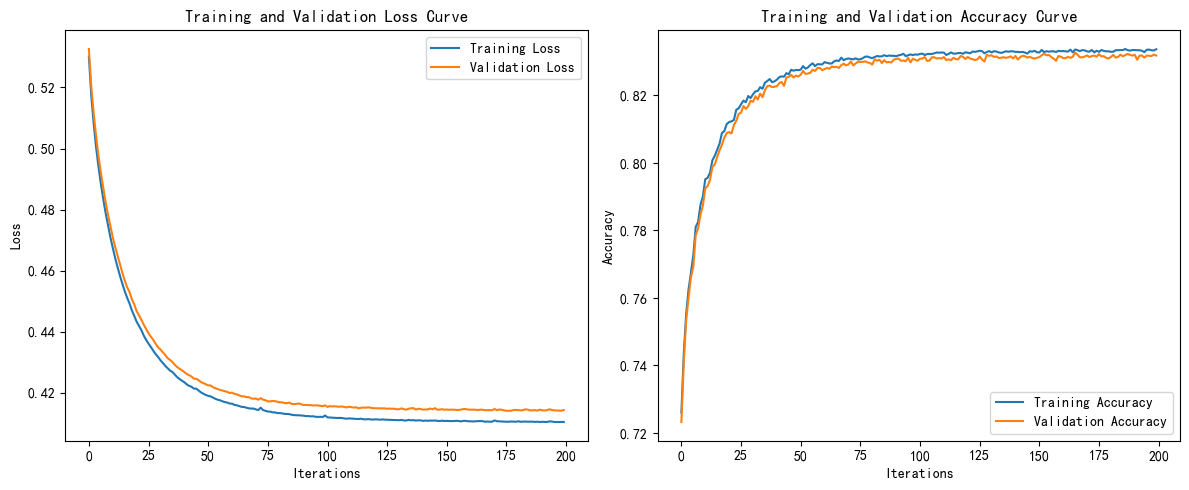

In [34]:
# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(mean_train_losses, label="Training Loss")
plt.plot(mean_val_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(mean_train_accuracies, label="Training Accuracy")
plt.plot(mean_val_accuracies, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# 定义特征贡献的计算函数
def feature_importance(weights, feature_names):
    feature_contribution = np.abs(weights)  # 计算权重的绝对值
    sorted_indices = np.argsort(-feature_contribution)  # 按绝对值降序排序
    sorted_features = [(feature_names[i], feature_contribution[i]) for i in sorted_indices]
    return sorted_features

# 计算并输出特征贡献
feature_names = X_train.columns  # 使用训练数据中的特征名称
sorted_features = feature_importance(final_weights, feature_names)

# 显示特征贡献
print("各特征对结果的贡献排序：")
for feature, contribution in sorted_features:
    print(f"{feature}: {contribution:.4f}")

各特征对结果的贡献排序：
capital_gain: 8.0477
relationship_ Wife: 0.2609
capital_loss: 0.2487
education_num: 0.2447
hours_per_week: 0.2361
relationship_ Husband: 0.2200
relationship_ Not-in-family: 0.2020
occupation_ Exec-managerial: 0.1994
age: 0.1896
marital_status_ Married-civ-spouse: 0.1810
education_ Prof-school: 0.1658
marital_status_ Never-married: 0.1440
occupation_ Farming-fishing: 0.1425
education_ Masters: 0.1417
education_ Doctorate: 0.1334
education_ HS-grad: 0.1091
relationship_ Unmarried: 0.1073
occupation_ Prof-specialty: 0.1005
relationship_ Own-child: 0.0989
occupation_ Machine-op-inspct: 0.0983
education_ Bachelors: 0.0950
sex_ Male: 0.0823
sex_ Female: 0.0823
occupation_ Handlers-cleaners: 0.0823
occupation_ Other-service: 0.0802
workclass_ Federal-gov: 0.0792
workclass_ Self-emp-inc: 0.0780
workclass_ Self-emp-not-inc: 0.0742
education_ 7th-8th: 0.0693
occupation_ Tech-support: 0.0687
education_ 9th: 0.0619
occupation_ Sales: 0.0570
marital_status_ Divorced: 0.0568
native_coun

In [36]:
# 定义预测函数
def predict(X, weights, threshold=0.5):
    probabilities = sigmoid(X @ weights)
    return (probabilities >= threshold).astype(int)

# 使用标准化后的测试数据进行预测
test_predictions = predict(X_test_standardized, final_weights)

# 创建预测结果的 DataFrame
result = pd.DataFrame({
    "id": [f"id_{i+1}" for i in range(len(test_predictions))],  # ID 从 1 开始编号
    "label": test_predictions.flatten()  # 将预测结果展平为一维数组
})

# 将结果保存为 CSV 文件
result.to_csv('output.csv', index=False)

print("预测结果已保存到文件 'output.csv'")

预测结果已保存到文件 'output.csv'


In [37]:
# # 使用整个训练集重新训练模型
# def retrain_model(X, y, learning_rate=0.01, num_iterations=1000):
#     weights = np.zeros(X.shape[1])
#     weights, _, _, _, _ = gradient_descent(X, y, X, y, weights, learning_rate, num_iterations)
#     return weights

# # 重新训练模型，得到最终的权重
# final_weights = retrain_model(X_train_np, Y_train_np)

# # 使用标准化后的测试数据进行预测
# test_predictions = predict(X_test_standardized, final_weights)